# Data challenge

Your task is to build an algorithm for prohibitory traffic sign recognition. We have
created a training data set (20 images) that can be used for building and fine-tuning a model.
However, you are encouraged to collect more images, since it will allow you to improve your
model’s performance.

There are 6 traffic sign categories your model should be able to recognize:
* Category A - no right, left, or U-turn
* Category B - speed limit (regardless of the indicated value)
* Category C - road closed
* Category D - no entry
* Category E - no stopping, no parking
* Category F - other types of prohibitory traffic signs

## Not I'll try to implement the [YOLOv8][1] in KerasCV, an extension of Keras for computer vision

Since pytorch is still a bit new to me and the origninal docs kind of forced me to upload our traffic to the roboflow website where they augmented the data without any code. I felt like that ruined the purpose of the data challenge. So now I'll follow this tutorial:

https://keras.io/examples/vision/yolov8/

[1]: https://keras.io/api/keras_cv/models/backbones/yolo_v8/


In [1]:
!pip install keras-cv==0.6.4
!pip install keras-nlp==0.6.3
!pip install -U pycocotools

  Obtaining dependency information for keras-cv==0.6.4 from https://files.pythonhosted.org/packages/be/4c/a45de94dcaa533bdf1dce1643321d57452c79e7b581c9d573facf10c7118/keras_cv-0.6.4-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.1/803.1 kB 4.6 MB/s eta 0:00:00a 0:00:01m
  Attempting uninstall: keras-cv
    Found existing installation: keras-cv 0.8.0.dev0
    Uninstalling keras-cv-0.8.0.dev0:
      Successfully uninstalled keras-cv-0.8.0.dev0
  Obtaining dependency information for keras-nlp==0.6.3 from https://files.pythonhosted.org/packages/16/37/e2bdca1975d3e5ebafb63dfcddc3b55369e012763f63abd7699dae8c0a45/keras_nlp-0.6.3-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.5/584.5 kB 3.8 MB/s eta 0:00:0000:0100:01m
  Attempting uninstall: keras-nlp
    Found existing installation: keras-nlp 0.7.0.dev3
    Uninstalling keras-nlp-0.7.0.dev3:
      Successfully uninstalled keras-nlp-0.7.0.dev3
  Obtaining dependency information for pycocoto

In [2]:
!pip list | grep keras

keras                                    2.13.1
keras-core                               0.1.7
keras-cv                                 0.6.4
keras-nlp                                0.6.3
keras-tuner                              1.3.5


In [3]:
# Import packages
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
import keras_cv
from keras_cv import bounding_box, visualization

# Set tensorflow backend for keras
os.environ["KERAS_BACKEND"] = "tensorflow"

# Set CUDA visible devices to GPU 0 and 1 (The 2xT4 GPUs that Kaggle provides)
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

# Define hyperparameters
SPLIT_RATIO = 0.5
BATCH_SIZE = 4
LEARNING_RATE = 0.001
EPOCH = 100
GLOBAL_CLIPNORM = 10.0

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using TensorFlow backend


# Load in the Traffic Sign Data

In [4]:
class_ids = [
    'no-right-left-or-u-turn',
    'speed-limit',
    'road-closed',
    'no-entry',
    'no-stopping-no-parking',
    'other'
]

class_mapping = dict(zip(range(len(class_ids)), class_ids))

# Path to images
path_images = '/kaggle/input/traffic-signs-data-challenge/train'

In [5]:
# Read the annotation file inot a pandas dataframe
annot_file = '/kaggle/input/traffic-signs-data-challenge/train/_annotations.csv'
annot_df = pd.read_csv(annot_file)

annot_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,17_jpg.rf.06cf807529216c05e2421a97e9a3c9aa.jpg,600,300,no-entry,22,149,60,177
1,17_jpg.rf.06cf807529216c05e2421a97e9a3c9aa.jpg,600,300,no-stopping-no-parking,520,160,570,198
2,17_jpg.rf.06cf807529216c05e2421a97e9a3c9aa.jpg,600,300,other,522,236,571,274
3,6_jpg.rf.8249332fe6bb156f9730dd96d112223f.jpg,600,300,road-closed,506,121,542,153
4,6_jpg.rf.8249332fe6bb156f9730dd96d112223f.jpg,600,300,other,555,97,597,131


In [6]:
grouped_df = annot_df.groupby(['filename']).agg({col:lambda x: list(x) for col in annot_df.columns[1:]}).reset_index()

grouped_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,10_jpg.rf.73da5bf11a250d18d212bd276be2a02e.jpg,"[600, 600, 600]","[300, 300, 300]","[road-closed, no-stopping-no-parking, speed-li...","[211, 515, 515]","[175, 107, 68]","[240, 557, 555]","[203, 143, 104]"
1,11_jpg.rf.788b737ab908f716125157158a741b1d.jpg,"[600, 600]","[300, 300]","[no-stopping-no-parking, no-entry]","[543, 6]","[67, 112]","[600, 42]","[142, 146]"
2,12_jpg.rf.f2fd7c2e462831e1225e480312289ad9.jpg,"[600, 600]","[300, 300]","[speed-limit, no-stopping-no-parking]","[521, 524]","[147, 186]","[556, 556]","[177, 214]"
3,13_jpg.rf.d5301f84fec055b793adabfb5e4ef329.jpg,"[600, 600, 600]","[300, 300, 300]","[speed-limit, other, no-stopping-no-parking]","[431, 432, 430]","[149, 120, 91]","[459, 460, 460]","[176, 149, 120]"
4,14_jpg.rf.b69dd2f82bdc031b0ccd416aaa8ffaf5.jpg,"[600, 600, 600]","[300, 300, 300]","[other, other, speed-limit]","[463, 456, 319]","[104, 158, 124]","[487, 496, 327]","[158, 213, 134]"


In [7]:
# Initialize lists to store information
image_paths = []
bbox = []
classes = []


def parse_annotation_csv(row):
    # Get the path pf the image
    image_name = row['filename']
    image_path = os.path.join(path_images, image_name)
    
    # Get the bounding box of the traffic sign
    xmin = row['xmin']
    ymin = row['ymin']
    xmax = row['xmax']
    ymax = row['ymax']
    
    # Combine coordinates into a list
    boxes = [[xmin[i], ymin[i], xmax[i], ymax[i]] for i in range(len(xmin))]
    
    # Get the class id of the traffic sign
    classes = row['class']
    class_ids = [
        list(class_mapping.keys())[list(class_mapping.values()).index(cls)]
        for cls in classes
    ]
    
    return image_path, boxes, class_ids

# Process annotations for each row in the DataFrame
for index, row in grouped_df.iterrows():
    image_path, boxes, class_ids = parse_annotation_csv(row)
    
    image_paths.append(image_path)
    bbox.append(boxes)
    classes.append(class_ids)

### Ragged tensors are used to create a tf.data.Dataset using the from_tensor_slices method. This method creates a dataset from the input tensors by slicing them along the first dimension. By using ragged tensors, the dataset can handle varying lengths of data for each image and provide a flexible input pipeline for further processing.

In [8]:
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

### Can we do one-hot encoding?

## Train Validation split

In [9]:
# Determine the number of validation samples
num_val = int(len(grouped_df) * SPLIT_RATIO)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)

In [10]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}


## Augmentation with the Natie KerasCV methods that are aware of the bounding boxes.

In [11]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        ),
    ]
)

## Creating Training Dataset

In [12]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

## Creating Validation Dataset

In [13]:
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

## Visualization

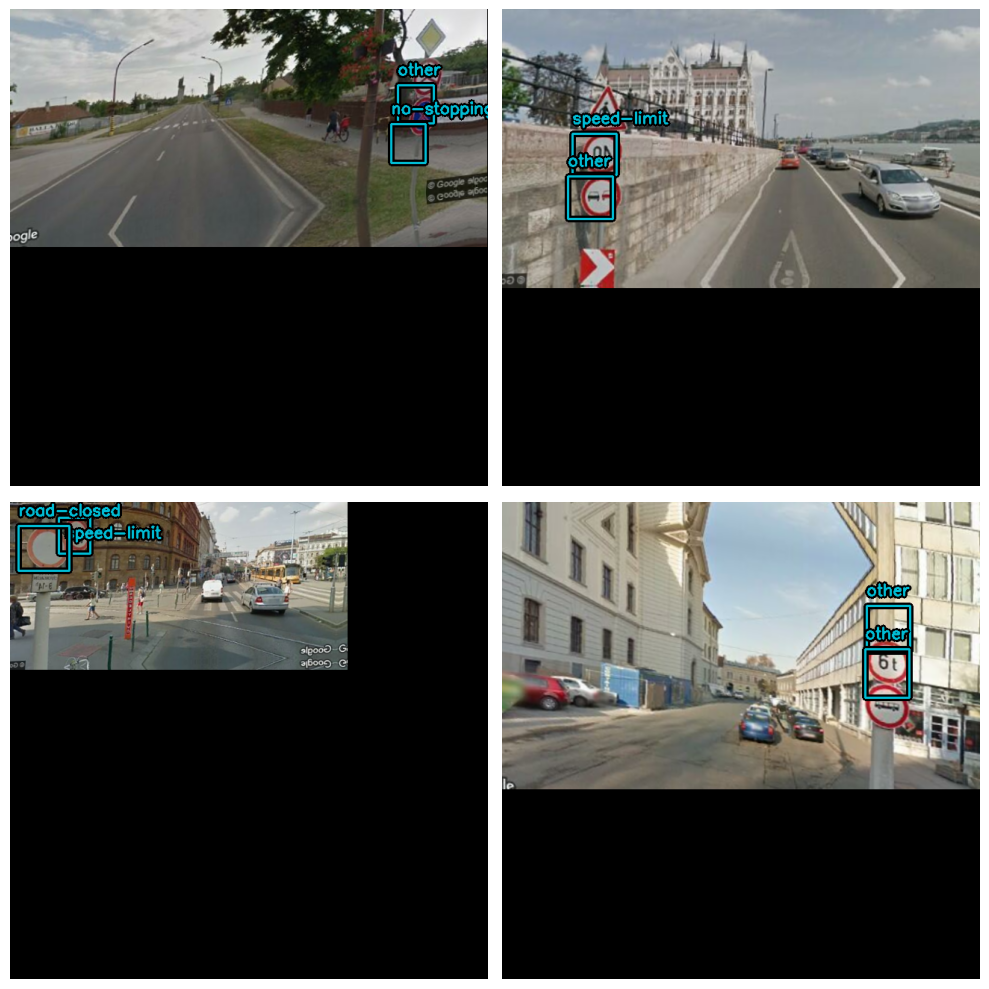

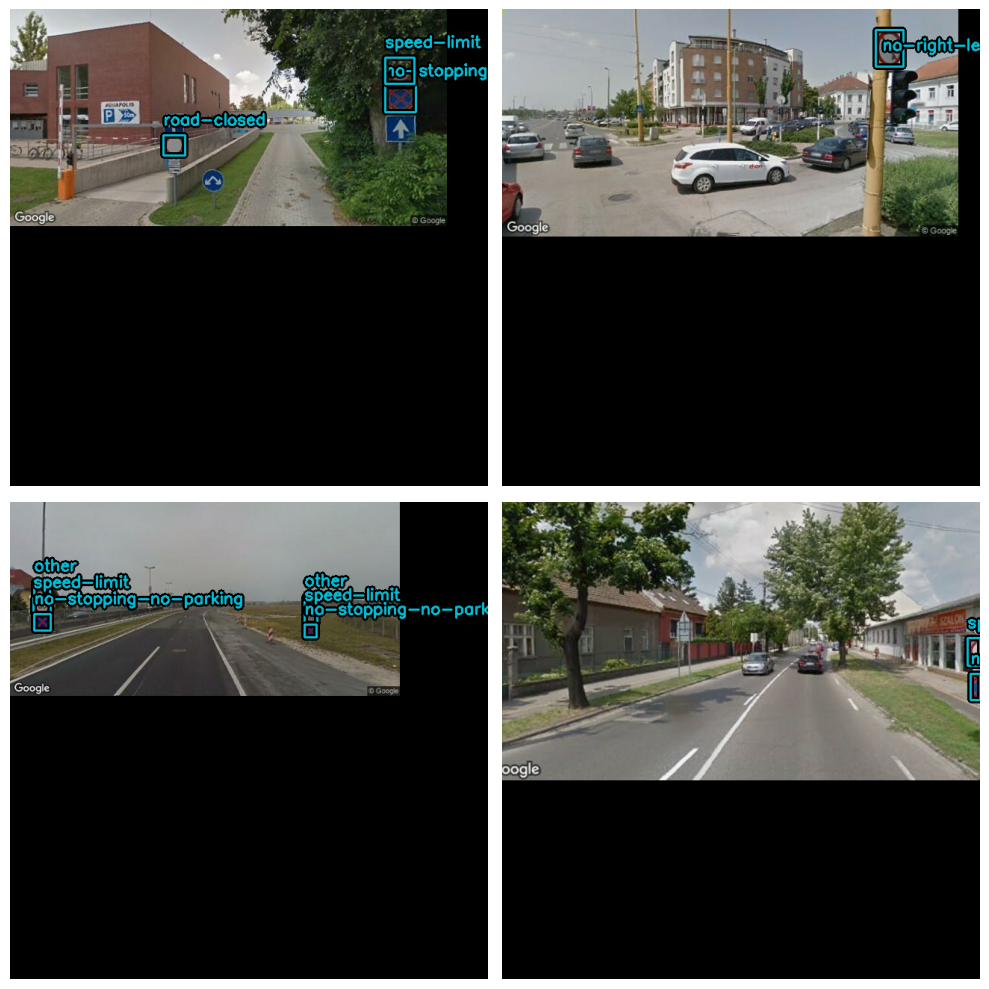

In [14]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(
    train_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

visualize_dataset(
    val_ds, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

In [15]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

# Implementing the YOLOv8 model in Keras

In [16]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco"
)

yolo = keras_cv.models.YOLOV8Detector(
    backbone=backbone,
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    fpn_depth=1,
)

optimizer = Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

20596968/20596968 [==============================] - 0s 0us/step


## COCO Metric Callback

We will be using `BoxCOCOMetrics` from KerasCV to evaluate the model and calculate the
Map(Mean Average Precision) score, Recall and Precision. We also save our model when the
mAP score improves.

In [17]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs

In [18]:
yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCH,
    #callbacks=[EvaluateCOCOMetricsCallback(val_ds, "model.h5")],
)

Epoch 1/100
2/2 [==============================] - 66s 4s/step - loss: 1827.3108 - box_loss: 5.2666 - class_loss: 1822.0442 - val_loss: 1341.9861 - val_box_loss: 6.4420 - val_class_loss: 1335.5439
Epoch 2/100
2/2 [==============================] - 1s 937ms/step - loss: 1430.5559 - box_loss: 4.4263 - class_loss: 1426.1295 - val_loss: 1689.4197 - val_box_loss: 6.6536 - val_class_loss: 1682.7660
Epoch 3/100
2/2 [==============================] - 1s 912ms/step - loss: 1667.3423 - box_loss: 4.5039 - class_loss: 1662.8384 - val_loss: 7945.1768 - val_box_loss: 4.8756 - val_class_loss: 7940.3008
Epoch 4/100
2/2 [==============================] - 1s 915ms/step - loss: 1182.3269 - box_loss: 3.9704 - class_loss: 1178.3564 - val_loss: 12737.5029 - val_box_loss: 3.9955 - val_class_loss: 12733.5078
Epoch 5/100
2/2 [==============================] - 1s 1s/step - loss: 1663.7711 - box_loss: 5.7043 - class_loss: 1658.0669 - val_loss: 8284.7881 - val_box_loss: 4.3433 - val_class_loss: 8280.4453
Epoch 6/

## Visualize detections

1/1 [==============================] - 5s 5s/step


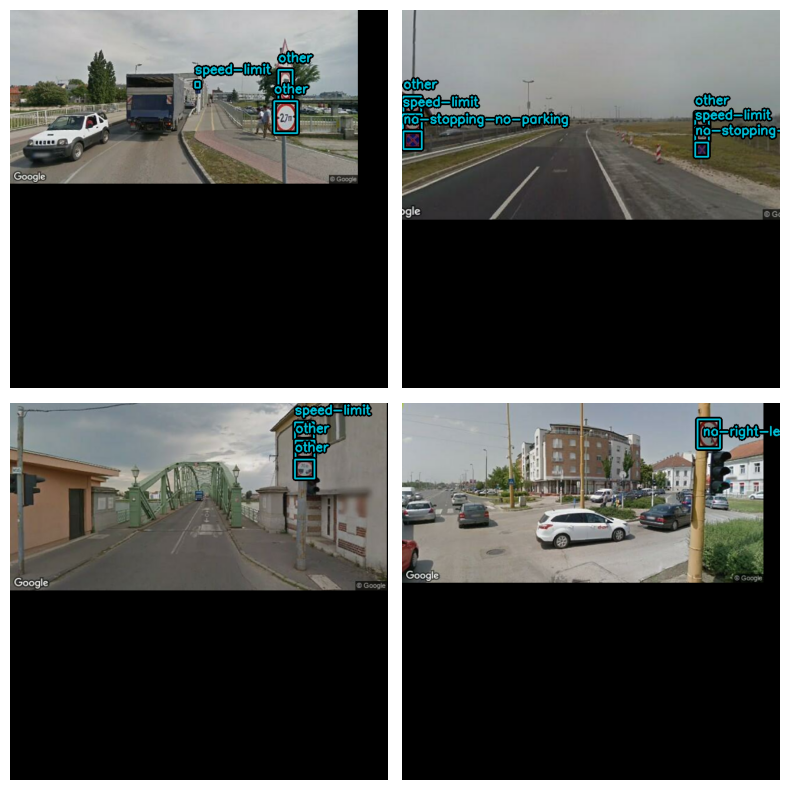

In [19]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


visualize_detections(yolo, dataset=val_ds, bounding_box_format="xyxy")